In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.applications.vgg16 import preprocess_input

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight


Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [5]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [6]:
def loadImages(path_data):
    
    p = '/home/jovyan/DATA_MASTER_PROJECT/C_diff_60_90/'
    
    
    
    pa_adr = p + 'ADR_cropped/'
    
    pa_control = p + 'CONTROL_cropped/'
    
    pa_hrh = p + 'HRH_cropped/'
    
    image_list = []
    
    
       


    for filename in tqdm.tqdm(sorted(path_data, key=natural_keys)): 
        
        if 'adr' in filename:
            
            im=cv2.imread(pa_adr + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'control' in filename:
            
            im=cv2.imread(pa_control + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'hrh' in filename:
            
            im=cv2.imread(pa_hrh + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)



    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))

    return x_orig

In [7]:
def return_count(x):
    name_wel = []
    for i in sorted(x, key = natural_keys):
        name_wel.append(i.split('_')[0])

    z = sorted(list(set(name_wel)))
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(x, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [8]:
def creat_label(y):
    labels = []
    for ix, _ in enumerate(y):
        
        if y[ix][0] == 'adr':
        
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'hrh' or y[ix][0] == 'control':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
    
    ler = [i for sub in labels for i in sub ]
    
    _, lab= zip(*ler)

    
    return lab

In [9]:
def make_labels(data_set):
    fe = return_count(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

# TEST SET

In [10]:
path_test = '/home/jovyan/DATA_MASTER_PROJECT/C_diff_60_90/ADR_cropped/'

# NAME OF THE WELLS CORRESPONDING TO THE FRUG THAT YOU WANT IN THE TEST SET 

wells_drug = ['C6', 'F11'] 

test = []

for _,_, filenames in os.walk(path_test):
    
    for filename in sorted(filenames, key = natural_keys):
    
        for w in wells_drug:
            
            if '{}'.format(w) in filename:
                test.append(filename)

# TRAIN & VALIDATION

In [11]:
groups_list = ['ADR', 'HRH']#, 'CONTROL']

fileds_of_view = ['1','2','3','4']

field_train, field_val = train_test_split(fileds_of_view, test_size=0.2, random_state=int(np.random.randint(1,1000,1)))


In [12]:
train = []

validation = []

group_compounds = []

In [13]:
for group in tqdm.tqdm(groups_list):
    
    pa = '/home/jovyan/DATA_MASTER_PROJECT/C_diff_60_90//{}_cropped/'.format(group)
    
    for _,_, filenames in os.walk(pa):
    
        for filename in sorted(filenames, key = natural_keys):

            if '_{}-'.format(wells_drug[0]) not in filename and '_{}-'.format(wells_drug[1]) not in filename :

                group_compounds.append(filename)

        
            
            
    

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


In [14]:
for i in group_compounds:
    
    for f in field_train:
        if '-{}_'.format(f) in i:
            train.append(i)
            
            
    for v in field_val:
        if '-{}_'.format(v) in i:
            validation.append(i)
            

In [15]:
x_train = loadImages(train)
y_train = make_labels(train)

x_train.shape, y_train.shape

100%|██████████| 80108/80108 [01:14<00:00, 1077.94it/s]


((80108, 90, 90, 3), (80108,))

In [16]:
x_val = loadImages(validation)
y_val = make_labels(validation)

x_val.shape, y_val.shape

100%|██████████| 26306/26306 [00:24<00:00, 1052.67it/s]


((26306, 90, 90, 3), (26306,))

In [17]:
x_test = loadImages(test)
y_test = make_labels(test)

x_test.shape, y_test.shape

100%|██████████| 14446/14446 [00:14<00:00, 1009.43it/s]


((14446, 90, 90, 3), (14446,))

In [18]:
x_train = resize(x_train)
x_train.shape

(80108, 64, 64, 3)

In [19]:
x_val = resize(x_val)
x_val.shape

(26306, 64, 64, 3)

In [20]:
x_test = resize(x_test)
x_test.shape

(14446, 64, 64, 3)

In [21]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
print('weights = ' + str(weights))

weights = [1.17422532 0.87079592]


In [22]:
x_train = preprocess_input(x_train)

x_val = preprocess_input(x_val)

x_test = preprocess_input(x_test)


#y_train = keras.utils.to_categorical(y_train)
#y_test_1 = keras.utils.to_categorical(y_test)
#y_val = keras.utils.to_categorical(y_val)

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [24]:
pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

In [25]:
batch_size = 128

In [26]:
datagen = ImageDataGenerator()

datagen.fit(x_train)

train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

m4 = Sequential()
m4.add(base_model)


m4.add(BatchNormalization())
m4.add(GlobalAveragePooling2D())
m4.add(BatchNormalization())
m4.add(Activation('relu'))
m4.add(Dense(64, activation='relu'))
m4.add(Dense(1,activation='sigmoid'))


base_model.trainable = False

opt = keras.optimizers.Adam(lr=1e-4)

m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])



epochs = 300

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = (val_gen), 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights,
                 verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625.84375 steps, validate for 205.515625 steps
Epoch 1/300
626/625 [==============================] - 23s 37ms/step - loss: 0.5971 - accuracy: 0.6737 - val_loss: 0.6951 - val_accuracy: 0.5849
Epoch 2/300
626/625 [==============================] - 20s 32ms/step - loss: 0.5159 - accuracy: 0.7440 - val_loss: 0.7282 - val_accuracy: 0.5905
Epoch 3/300
626/625 [==============================] - 19s 31ms/step - loss: 0.4616 - accuracy: 0.7790 - val_loss: 0.7787 - val_accuracy: 0.5819
Epoch 4/300
626/625 [==============================] - 20s 31ms/step - loss: 0.4222 - accuracy: 0.8042 - val_loss: 0.7938 - val_accuracy: 0.5991
Epoch 00004: early stopping


In [27]:
base_model.trainable = True

opt = keras.optimizers.Adam(lr=1e-5)

m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

epochs = 300

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights,
                verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625.84375 steps, validate for 205.515625 steps
Epoch 1/300
626/625 [==============================] - 45s 71ms/step - loss: 0.3684 - accuracy: 0.8386 - val_loss: 0.8253 - val_accuracy: 0.5912
Epoch 2/300
626/625 [==============================] - 43s 69ms/step - loss: 0.3315 - accuracy: 0.8610 - val_loss: 0.8401 - val_accuracy: 0.5901
Epoch 3/300
626/625 [==============================] - 43s 68ms/step - loss: 0.3054 - accuracy: 0.8775 - val_loss: 0.9047 - val_accuracy: 0.5759
Epoch 4/300
626/625 [==============================] - 43s 68ms/step - loss: 0.2835 - accuracy: 0.8887 - val_loss: 0.8671 - val_accuracy: 0.5951
Epoch 00004: early stopping


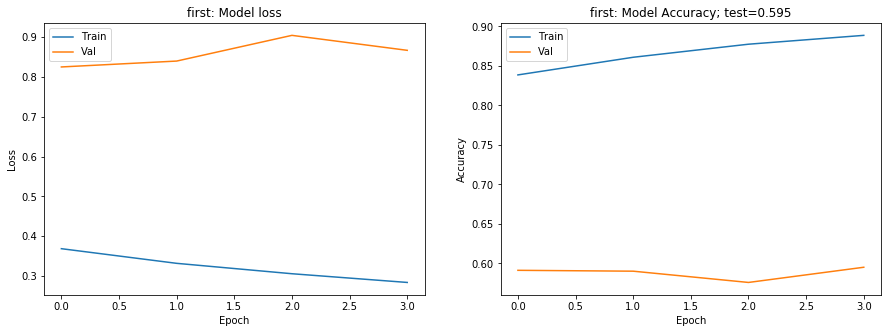

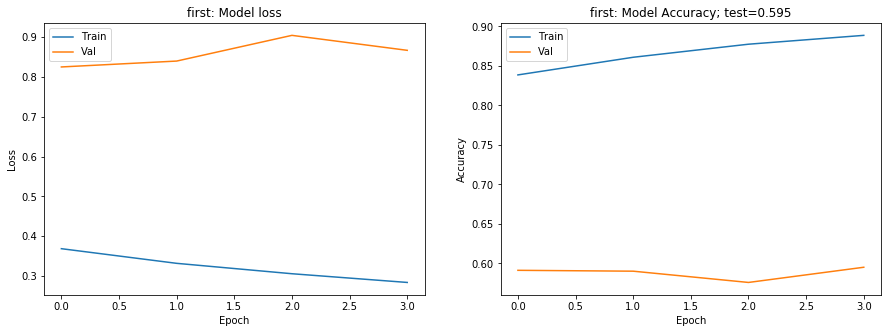

In [28]:
plot_history(m4_h, 'first')

In [29]:
scores = m4.evaluate(x_test, y_test, verbose = 0)
print("\n%s: %.2f%%" % (m4.metrics_names[1], scores[1]*100))



accuracy: 28.61%


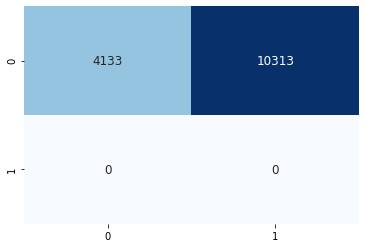

array([[ 4133, 10313],
       [    0,     0]])

In [30]:
test_preds = m4.predict(x_test)

t= []
for i in (test_preds):
    if i > 0.5:
        t.append(1)
    else:
        t.append(0)

draw_confusion_matrix(y_test, t)

In [ ]:
#p = '/home/jovyan/Saved_Models/'
#m4.save(p + "FINAL.h5")

In [31]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [32]:
y_val

array([0, 0, 0, ..., 1, 1, 1])